In [1]:
data_path = "../data/annotated_data"
save_model_dir_name = "best_model_distilbert"
# set to true if colab!
colab = False
train_model = False
if colab:
    data_path = '/content/drive/MyDrive/annotated_data'
    !pip install transformers
    !pip install evaluate
    !pip install seaborn
    !pip install accelerate
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except:
        print("probably not in colab")

# Imports

In [2]:
import os
import ast
import json
import torch
torch.manual_seed(0)
import random
random.seed(0)
import itertools
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, DistilBertForSequenceClassification,get_scheduler
from sklearn import preprocessing
from tqdm.auto import tqdm

# Load Data

In [3]:
files = [f for f in os.listdir(data_path) if f.endswith('jsonl')]
rows = []

In [4]:
for f in files:
    with open(f'{data_path}/{f}', 'r') as json_file:
        json_list = list(json_file)
    for json_str in json_list:
        result = json.loads(json_str)
        label = result["label"]
        text = result["text"]
        new_spans = []
        if result["spans"] and len(result["spans"]) != 0:
            try:
                new_spans = [s["text"] for s in result["spans"]]
            except:
                x = ast.literal_eval(result["spans"])
                new_spans = [s["text"] for s in x]
        new_row = {
            "text":text,
            "label":label,
            "spans":new_spans
        }
        rows.append(new_row)
    print(f"Loaded: {f}")
df = pd.DataFrame(rows)

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


## Inspecting the data

Text(0.5, 1.0, 'number of examples per class')

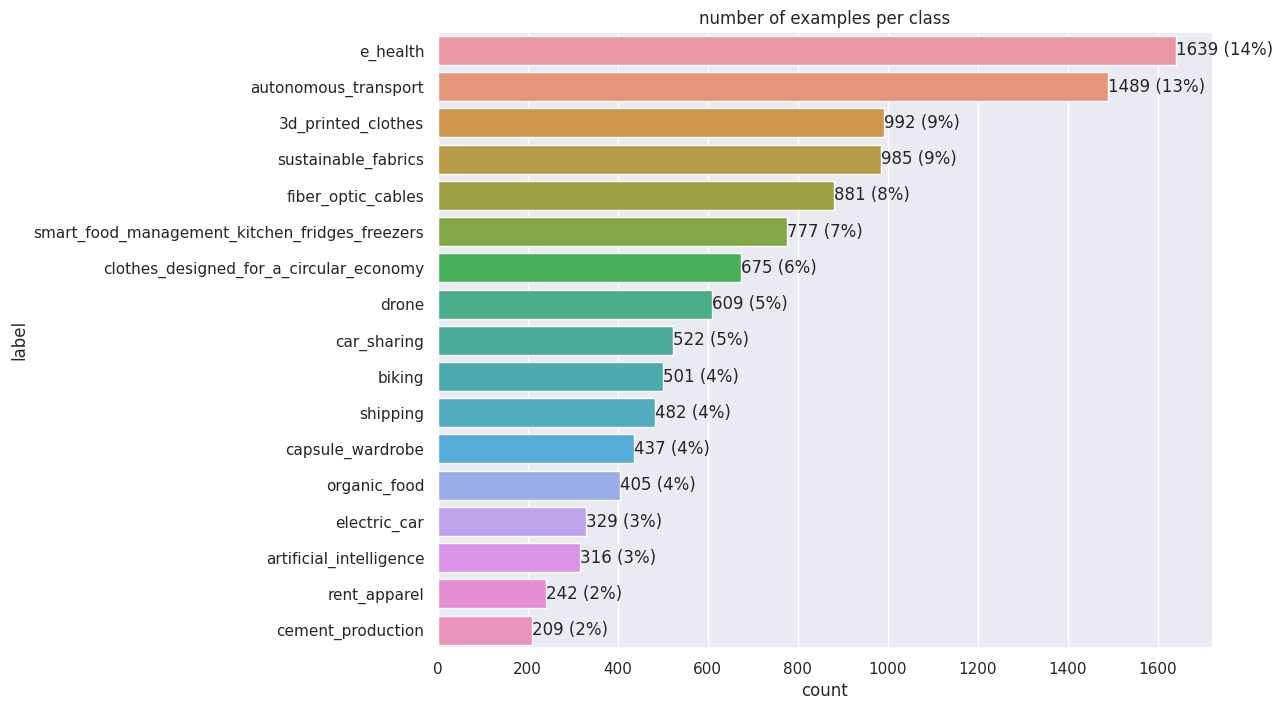

In [5]:
plt.figure(figsize=(10,8))

abs_values = df['label'].value_counts(ascending=False)
g = sns.countplot(data=df, y="label", order=abs_values.index)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
bar_labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values.values, rel_values)]
g.bar_label(container=g.containers[0], labels=bar_labels)
g.set_title("number of examples per class")

text length statistics


,mean,median,min,max
label,,,,
3d_printed_clothes,383.121976,380.5,57,1054
artificial_intelligence,470.534810,458.0,184,952
autonomous_transport,415.642042,403.0,14,2315
biking,419.335329,409.0,112,1187
capsule_wardrobe,358.945080,321.0,73,1189
car_sharing,318.021073,311.0,16,848
cement_production,450.602871,439.0,35,1119
clothes_designed_for_a_circular_economy,432.047407,414.0,123,1195
drone,410.180624,412.0,16,1655


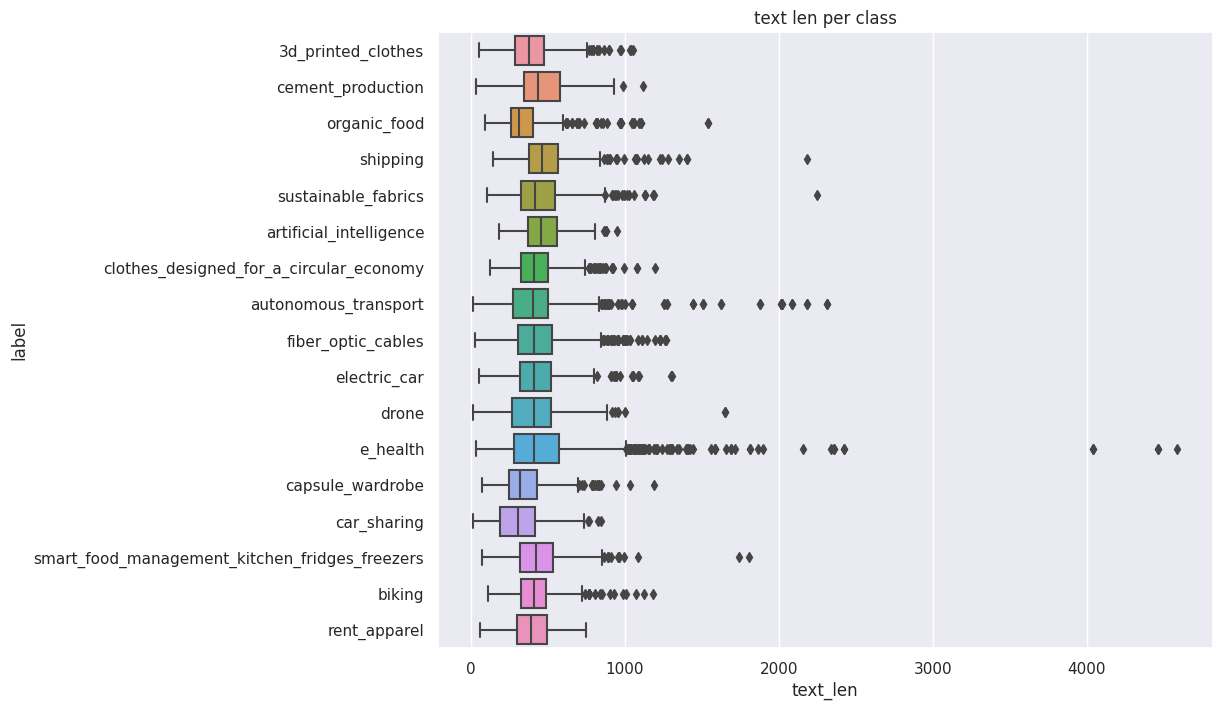

In [6]:
df["text_len"] = df[["text"]].apply(lambda x:len(x.item()), axis=1)
plt.figure(figsize=(10,8))
g = sns.boxplot(data=df, x="text_len", y="label")
g.set_title("text len per class")
print("text length statistics")
df.groupby(["label"])["text_len"].agg(["mean","median","min","max"])

# Data Preparation
## Encode Labels

In [7]:
le = preprocessing.LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

## Train, Valdiation and Test Split

In [8]:
# 70, 20, 10 split
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [9]:
# collect spans from the training data-set
new_spans = set(itertools.chain.from_iterable(train_df.spans.tolist()))

# Create Datasets and Tokenize

In [10]:
# add new spans to the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=False)
# extend tokenizer with domain spans
new_tokens = set(new_spans) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(new_tokens))

244

In [11]:
# define PyTorch dataset
class TAndIDataSet(Dataset):
    def __init__(self, text_column, encoded_labels):
        self.texts = text_column
        self.encodings = tokenizer(text_column.tolist(), truncation=True, padding=True, max_length=512)
        self.labels = encoded_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item, self.texts[idx]

    def __len__(self):
        return len(self.labels)

In [12]:
# create datasets
train_dataset = TAndIDataSet(train_df.text, train_df.label_encoded)
val_dataset = TAndIDataSet(val_df.text, val_df.label_encoded)
test_dataset = TAndIDataSet(test_df.text, test_df.label_encoded)
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader =  DataLoader(test_dataset, batch_size=32)

# Finetuning
## Definitions

In [13]:
if train_model:
    # model definition
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(le.classes_)
    ).to("cuda")
    # adjust embeddings size for new vocabulary length
    model.resize_token_embeddings(len(tokenizer))
else:
    tokenizer = AutoTokenizer.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True)
    model = DistilBertForSequenceClassification.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True).to("cuda")

In [14]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# epochs
num_epochs = 10
# learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader)
)

## Training Loop

In [15]:
if train_model:
    training_stats = []
    progress_bar = tqdm(range(num_epochs*(len(train_dataloader)+len(val_dataloader))))
    for epoch in range(num_epochs):
        print(f"\nRunning Epoch {epoch+1}/{num_epochs}...")
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_correct = 0
        epoch_val_correct = 0
        best_val_loss = np.Inf
        # training loop
        model.train()
        for batch, _ in train_dataloader:
            # move batch to gpu
            batch = {k: v.to("cuda") for k, v in batch.items()}
            # forward pass
            output = model(**batch)
            predictions = torch.argmax(output.logits, dim=-1)
            epoch_train_correct += (predictions == batch["labels"].flatten()).long().sum()
            # compute loss & backprop
            loss = output.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # reset optimizer
            optimizer.zero_grad()
            # save batch_loss
            epoch_train_losses.append(loss.item())
            progress_bar.update(1)
        # validation loop
        model.eval()
        for batch, _ in val_dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            with torch.no_grad():
                output = model(**batch)
                predictions = torch.argmax(output.logits, dim=-1)
                epoch_val_correct += (predictions == batch["labels"].flatten()).long().sum()
                epoch_val_losses.append(output.loss.item())
            progress_bar.update(1)
        # save epoch metrics
        epoch_stats = {
            "epoch":epoch,
            "train_loss":np.mean(epoch_train_losses),
            "val_loss":np.mean(epoch_val_losses),
            "train_accuracy":epoch_train_correct.item()/len(train_dataset),
            "val_accuracy":epoch_val_correct.item()/len(val_dataset)
        }
        print(epoch_stats)
        # save best model
        if np.mean(epoch_val_losses) < best_val_loss:
            model_path = f"./{save_model_dir_name}"
            model.save_pretrained(model_path)
            tokenizer.save_pretrained(model_path)
            best_val_loss = np.mean(epoch_val_losses)
        training_stats.append(epoch_stats)
    # if colab make sure to save best model to google drive
    training_stats = pd.DataFrame(training_stats)
    if colab:
        !cp -r $save_model_dir_name /content/drive/MyDrive
else:
    print("training disabled")

training disabled


In [16]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_loss","val_loss"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

In [17]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_accuracy","val_accuracy"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

# Testing

In [18]:
progress_bar = tqdm(range(len(test_dataloader)))
test_correct = 0
test_predictions = []
model.eval()
softmax = torch.nn.Softmax(dim=len(le.classes_))
for batch, texts in test_dataloader:
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        output = model(**batch)
        local_predictions = torch.argmax(output.logits, dim=-1)
        top_k_predictions = torch.topk(output.logits, k=3)
        test_correct += (local_predictions == batch["labels"].flatten()).long().sum()
        for idx, pred in enumerate(local_predictions.tolist()):
            test_predictions.append({
                "y_hat_enc":pred,
                "y_enc":batch["labels"].flatten().tolist()[idx],
                "text":texts[idx],
                "top_k":top_k_predictions.indices[idx].tolist(),
                "top_k_logits": top_k_predictions.values[idx].tolist(),
                "in_top_k":batch["labels"].flatten().tolist()[idx] in top_k_predictions.indices[idx].tolist()
            })
    progress_bar.update(1)
print(f"Test Accuracy: {test_correct/(len(test_dataloader)*test_dataloader.batch_size)}")
test_predictions = pd.DataFrame(test_predictions)
test_predictions["y"] = le.inverse_transform(test_predictions["y_enc"])
test_predictions["y_hat"] = le.inverse_transform(test_predictions["y_hat_enc"])
print(f"Test top-k Accuracy: {len(test_predictions.loc[test_predictions.in_top_k])/(len(test_dataloader)*test_dataloader.batch_size)}")

  0%|          | 0/36 [00:00<?, ?it/s]

Test Accuracy: 0.9253472089767456
Test top-k Accuracy: 0.9756944444444444


## Wrong classifications

In [19]:
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].head(n=1000)

,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
5,2,11,One shortcoming of the tip-tilt style tracker ...,"[2, 11, 10]","[7.092034816741943, 3.5652966499328613, -0.062...",True,fiber_optic_cables,autonomous_transport
11,9,15,The entire transport and logistics industry (i...,"[9, 15, 2]","[8.735118865966797, 0.02586361952126026, -0.25...",True,smart_food_management_kitchen_fridges_freezers,e_health
18,0,2,- The National Law Review (2019) Autonomous Ve...,"[0, 2, 5]","[7.433714866638184, 0.08240626007318497, -0.72...",True,autonomous_transport,3d_printed_clothes
41,2,11,"21. Also, theoretical output, which is based o...","[2, 11, 10]","[7.282090663909912, 3.1001853942871094, -0.141...",True,fiber_optic_cables,autonomous_transport
47,11,4,Your capsule wardrobe can be whatever you want...,"[11, 4, 0]","[5.366136074066162, 1.6908034086227417, -0.098...",True,capsule_wardrobe,fiber_optic_cables
...,...,...,...,...,...,...,...,...
1077,2,5,"Part A Gen. 1988, 22, 151–161. [Google Scholar...","[2, 5, 10]","[3.6104109287261963, 2.5072498321533203, 1.280...",True,car_sharing,autonomous_transport
1080,0,2,(2015) Revolution in the Driver’s Seat: The Ro...,"[0, 2, 10]","[6.522218227386475, 2.9363865852355957, -0.688...",True,autonomous_transport,3d_printed_clothes
1085,5,2,J. Appl. Soc. Psychol.,"[5, 8, 2]","[4.388692855834961, 3.5870981216430664, 3.3598...",True,autonomous_transport,car_sharing
1095,5,13,Sharing Drives the Apparel Rental Trend\nThe r...,"[5, 3, 9]","[7.212112903594971, 0.42473065853118896, 0.125...",False,rent_apparel,car_sharing


In [20]:
print("num. miss-classifications per class")
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].groupby(["y"])["y"].count()

num. miss-classifications per class


y
3d_printed_clothes                                 6
autonomous_transport                              19
biking                                             1
capsule_wardrobe                                   4
car_sharing                                        9
cement_production                                  1
clothes_designed_for_a_circular_economy            7
drone                                              2
e_health                                           5
electric_car                                      11
fiber_optic_cables                                 6
rent_apparel                                       2
shipping                                           2
smart_food_management_kitchen_fridges_freezers     4
sustainable_fabrics                                4
Name: y, dtype: int64

### Confusion Matrix

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics


Text(0.5, 43.249999999999986, 'y_hat')

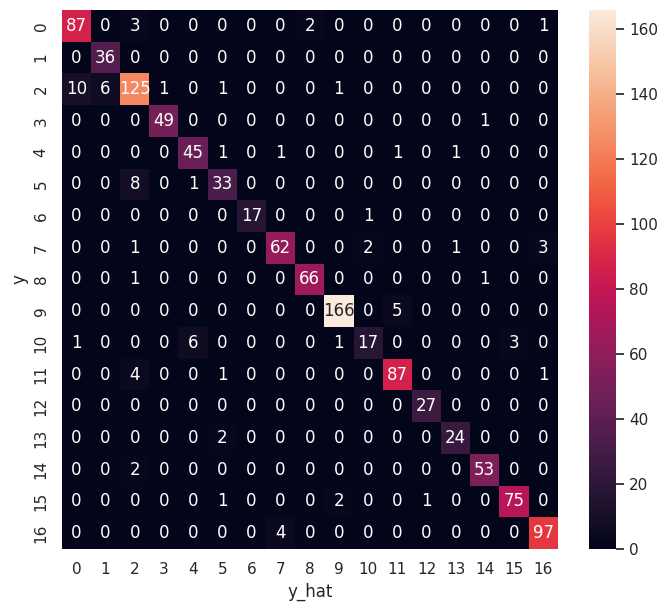

In [21]:
# axis_ticks = le.inverse_transform(list(range(0,17)))
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
cm = confusion_matrix(test_predictions["y_enc"],test_predictions["y_hat_enc"])
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g')
g.set_ylabel("y")
g.set_xlabel("y_hat")

### Detailed inspection of miss-classifications

In [26]:
# class of interest
coi = "autonomous_transport"
coi_miss = test_predictions.loc[(test_predictions.y==coi) & (test_predictions.y_hat != coi)]
print(f"Total num. miss: {len(coi_miss)}, non-top-k miss: {len(coi_miss.loc[~coi_miss.in_top_k])}")
coi_miss_enhanced = []
for idx, row in coi_miss.iterrows():
    for tk in range(len(row.top_k)):
        new_row = {
            "score": row.top_k_logits[tk],
            "y_hat_enc": row.top_k[tk],
            "y_hat": le.inverse_transform([row.top_k[tk]])[0],
            "rank":str(tk)
        }
        coi_miss_enhanced.append(new_row)
coi_miss_enhanced = pd.DataFrame(coi_miss_enhanced)
coi_miss

Total num. miss: 19, non-top-k miss: 5


,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
18,0,2,- The National Law Review (2019) Autonomous Ve...,"[0, 2, 5]","[7.433714866638184, 0.08240626007318497, -0.72...",True,autonomous_transport,3d_printed_clothes
136,1,2,"Faster, lighter and more powerful sensors are ...","[1, 15, 9]","[3.8053817749023438, 3.3708417415618896, -0.02...",False,autonomous_transport,artificial_intelligence
195,0,2,"8 Autonomous Driving—Political, Legal, … 163\n...","[0, 7, 16]","[9.194976806640625, -0.17436818778514862, -1.3...",False,autonomous_transport,3d_printed_clothes
211,1,2,There are still critical technical issues that...,"[1, 14, 2]","[7.0131683349609375, 0.5164768695831299, -0.11...",True,autonomous_transport,artificial_intelligence
214,0,2,"Référence électronique\nLaura Brimont, Mathieu...","[0, 6, 16]","[2.4972622394561768, 1.1561256647109985, 0.982...",False,autonomous_transport,3d_printed_clothes
221,9,2,Excellent statistical results of current AI me...,"[9, 15, 2]","[5.028407096862793, 3.7464189529418945, 0.3434...",True,autonomous_transport,e_health
226,0,2,"The travel, energy and carbon impacts of highl...","[0, 2, 16]","[6.435678482055664, 3.057004690170288, -1.4029...",True,autonomous_transport,3d_printed_clothes
257,1,2,These strategic\ndocuments cover issues linked...,"[1, 2, 14]","[6.326166152954102, 0.9293381571769714, -0.439...",True,autonomous_transport,artificial_intelligence
374,3,2,The needs for regulation and further\nresearch...,"[3, 2, 1]","[1.8723548650741577, 1.4473602771759033, 0.796...",True,autonomous_transport,biking
412,0,2,The End of Driving. Transportation Systems and...,"[0, 7, 13]","[9.093282699584961, -0.782386302947998, -1.243...",False,autonomous_transport,3d_printed_clothes


rank 0 should be 'autonomous_transport'


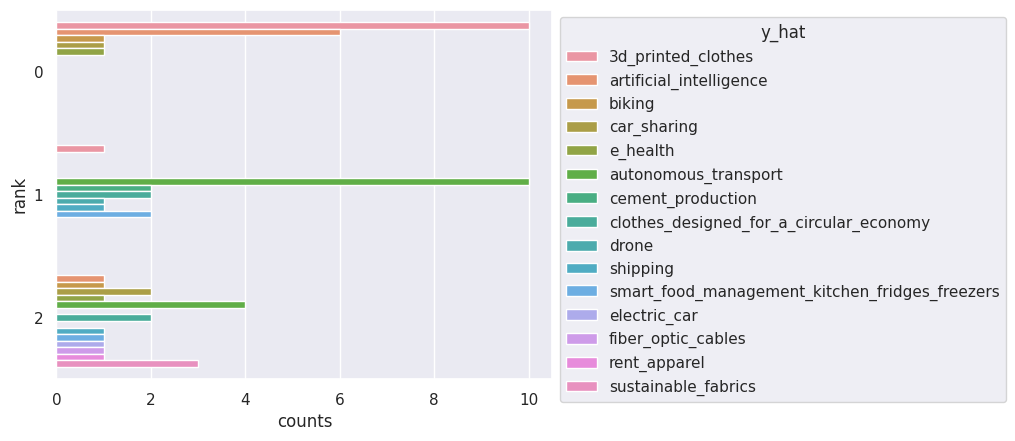

In [27]:
print(f"rank 0 should be '{coi}'")
coi_miss_enhanced_agg = coi_miss_enhanced.groupby(['rank',"y_hat","y_hat_enc"]).size().reset_index(name="counts")
g = sns.barplot(data=coi_miss_enhanced_agg, y="rank", x="counts", hue="y_hat")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#### Inspecting text of non top-k correct classifications

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics
Num of non-top-k predictions: 25


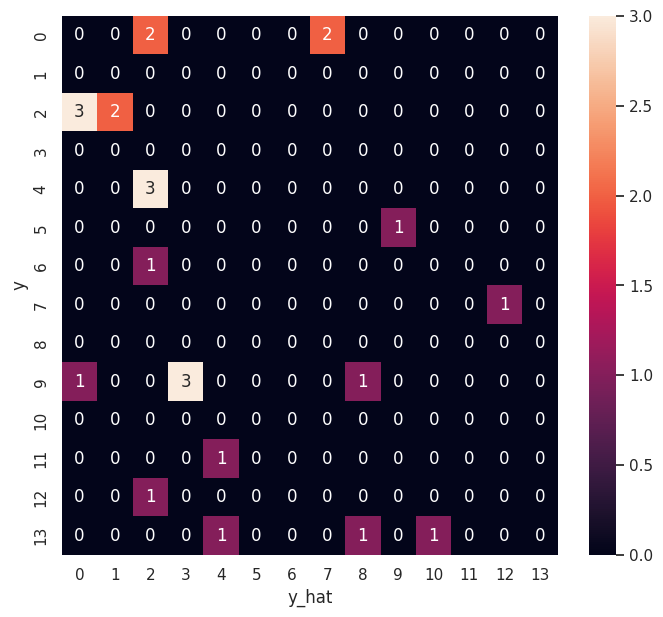

In [24]:
non_top_k = test_predictions.loc[~test_predictions.in_top_k]
#axis_ticks = le.inverse_transform(list(set(list(non_top_k.y_hat_enc.unique()) + list(non_top_k.y_enc.unique()))))
cm = confusion_matrix(non_top_k["y_enc"],non_top_k["y_hat_enc"])
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g')
g.set_ylabel("y")
g.set_xlabel("y_hat")
print(f"Num of non-top-k predictions: {len(non_top_k)}")

In [25]:
for idx, row in non_top_k.sort_values(by=['y']).iterrows():
    print(f"[{idx}]")
    print(f"class: {row.y}, predicted: {row.y_hat}")
    print(row.text)
    print("--------------")

[1137]
class: 3d_printed_clothes, predicted: autonomous_transport
3D design tools
In their attempts to generate sustainable 3D fashion notions and accessories, both researchers trained themselves using a variety of relevant software training videos, identifying the design opportunities and limitations of each tool. Researcher A and B explored a variety of software design tools, settling on Tinkercad, Rhinoceros 5, and MakerBot Replicator 2. Initially, Autodesk 123d Design and 3D scanning were explored.
--------------
[963]
class: 3d_printed_clothes, predicted: drone
MakerBot uses virgin materials such as polylactic Acid (PLA) (corn-based), Acrylonitrile Butadiene Styrene (ABS), and flexible filament. PLA is preferred because it is biodegradable, has a lower melting point, and has higher dimensional stability as compared to ABS; however, PLA is water-soluble and not best for long-term wear (Pei et al. 2015; Samuels and Flowers 2015).
--------------
[827]
class: 3d_printed_clothes, predi